# 🎯 Optimized GAT Training for Overflow-Underflow & Re-entrancy Detection
## SolidiFI Benchmark - Enhanced Pipeline

This notebook implements an optimized Graph Attention Network (GAT) for detecting:
- **Overflow-Underflow** (Arithmetic vulnerabilities)
- **Re-entrancy** vulnerabilities

Key optimizations:
- Enhanced feature extraction with 20+ patterns
- Focal Loss with label smoothing
- Per-class threshold optimization
- Class weighting for imbalanced data
- Data augmentation strategies

## 1. Setup Environment and Dependencies

In [1]:
# Install dependencies
!pip install -q torch-geometric
!pip install -q pandas scikit-learn matplotlib seaborn tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import re
import random
import numpy as np
import urllib.request
import zipfile
import io
import json
from collections import Counter
from tqdm import tqdm

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, global_mean_pool, global_max_pool, global_add_pool
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
import seaborn as sns

# Seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ PyTorch: {torch.__version__}")
print(f"✅ Device: {device}")
print(f"✅ CUDA Available: {torch.cuda.is_available()}")

C:\Users\Admin\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ PyTorch: 2.9.1+cpu
✅ Device: cpu
✅ CUDA Available: False


## 2. Clone and Load SolidiFI Benchmark Dataset

In [2]:
print("=" * 80)
print("📥 DOWNLOADING SOLIDIFI-BENCHMARK DATA")
print("=" * 80)

# Directories
BASE_DIR = "."
DATA_DIR = os.path.join(BASE_DIR, "data", "solidifi_optimized")
MODEL_SAVE_DIR = os.path.join(BASE_DIR, "saved_models")
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

SOLIDIFI_URL = "https://github.com/DependableSystemsLab/SolidiFI-benchmark/archive/refs/heads/master.zip"
SOLIDIFI_DIR = os.path.join(DATA_DIR, "SolidiFI-benchmark")

def download_solidifi():
    """Download and extract SolidiFI-benchmark"""
    if os.path.exists(SOLIDIFI_DIR):
        print("   ✅ SolidiFI-benchmark already exists")
        return True
    
    print("   📥 Downloading SolidiFI-benchmark...")
    try:
        response = urllib.request.urlopen(SOLIDIFI_URL, timeout=180)
        with zipfile.ZipFile(io.BytesIO(response.read())) as z:
            z.extractall(DATA_DIR)
        
        # Rename extracted folder
        extracted = os.path.join(DATA_DIR, "SolidiFI-benchmark-master")
        if os.path.exists(extracted):
            import shutil
            if os.path.exists(SOLIDIFI_DIR):
                shutil.rmtree(SOLIDIFI_DIR)
            os.rename(extracted, SOLIDIFI_DIR)
        
        print("   ✅ Downloaded successfully")
        return True
    except Exception as e:
        print(f"   ❌ Download failed: {e}")
        return False

download_solidifi()

# Target vulnerabilities
TARGET_VULNS = ['Overflow-Underflow', 'Re-entrancy']
VULN_LABELS = {
    'Overflow-Underflow': 0,
    'Re-entrancy': 1,
}
NUM_CLASSES = 2

print(f"\n📋 Target Vulnerabilities: {TARGET_VULNS}")

📥 DOWNLOADING SOLIDIFI-BENCHMARK DATA
   📥 Downloading SolidiFI-benchmark...
   ❌ Download failed: [WinError 5] Access is denied: '.\\data\\solidifi_optimized\\SolidiFI-benchmark-master' -> '.\\data\\solidifi_optimized\\SolidiFI-benchmark'

📋 Target Vulnerabilities: ['Overflow-Underflow', 'Re-entrancy']


## 3. Data Processing with Enhanced Feature Extraction

Enhanced regex patterns specifically designed for:
- **Arithmetic operations**: SafeMath absence, unchecked blocks, overflow-prone patterns
- **Re-entrancy patterns**: External calls before state changes, call.value patterns

In [3]:
# Enhanced Feature Extraction for Target Vulnerabilities
NUM_FEATURES = 32  # Optimized feature count

class EnhancedFeatureExtractor:
    """
    Enhanced feature extraction for Overflow-Underflow and Re-entrancy
    """
    def __init__(self, num_features=32):
        self.num_features = num_features
        
        # Pattern definitions with weights
        self.patterns = {
            # ============ OVERFLOW-UNDERFLOW PATTERNS ============
            'arithmetic_add': (r'\+\s*(?!=)', 3),
            'arithmetic_sub': (r'-\s*(?!=)', 3),
            'arithmetic_mul': (r'\*\s*(?!=)', 3),
            'arithmetic_div': (r'/\s*(?!=)', 2),
            'arithmetic_exp': (r'\*\*', 4),
            'unchecked_block': (r'unchecked\s*\{', 5),
            'no_safemath': (r'using\s+SafeMath', -5),
            'uint_overflow': (r'uint\d*\s+\w+\s*[+\-*]', 4),
            'increment': (r'\+\+|\+=', 2),
            'decrement': (r'--|-=', 2),
            'loop_counter': (r'for\s*\([^)]*\+\+[^)]*\)', 3),
            'balance_calc': (r'balance\s*[+\-*\/]', 4),
            
            # ============ RE-ENTRANCY PATTERNS ============
            'external_call': (r'\.call\s*\{?', 5),
            'call_value': (r'\.call\{value:', 6),
            'call_value_old': (r'\.call\.value\s*\(', 6),
            'send_ether': (r'\.send\s*\(', 4),
            'transfer_ether': (r'\.transfer\s*\(', 3),
            'delegatecall': (r'\.delegatecall\s*\(', 5),
            'state_after_call': (r'\.call[^;]*;\s*\n\s*\w+\s*=', 7),
            'msg_value': (r'msg\.value', 3),
            'payable': (r'\bpayable\b', 2),
            'fallback': (r'fallback\s*\(\s*\)', 3),
            
            # ============ PROTECTION PATTERNS (negative weights) ============
            'require': (r'require\s*\(', -1),
            'assert': (r'assert\s*\(', -1),
            'nonreentrant': (r'nonReentrant|ReentrancyGuard', -5),
            'modifier': (r'modifier\s+\w+', -1),
            'onlyowner': (r'onlyOwner', -1),
        }
    
    def extract_features(self, source_code, vuln_type=None):
        """Extract feature vector from Solidity source code"""
        features = []
        
        # Pattern-based features
        for pattern_name, (pattern, weight) in self.patterns.items():
            matches = len(re.findall(pattern, source_code, re.IGNORECASE | re.MULTILINE))
            weighted_count = matches * abs(weight) / 10.0
            if weight < 0:
                weighted_count = -weighted_count
            features.append(min(max(weighted_count, -1.0), 1.0))
        
        # Statistical features
        lines = source_code.split('\n')
        features.append(min(len(lines) / 500.0, 1.0))
        features.append(min(len(source_code) / 10000.0, 1.0))
        
        # Function complexity
        functions = re.findall(r'function\s+\w+', source_code)
        features.append(min(len(functions) / 20.0, 1.0))
        
        # Vulnerability-specific boost
        if vuln_type == 'Overflow-Underflow':
            has_safemath = bool(re.search(r'using\s+SafeMath', source_code, re.IGNORECASE))
            features.append(0.0 if has_safemath else 1.0)
        elif vuln_type == 'Re-entrancy':
            has_guard = bool(re.search(r'nonReentrant|ReentrancyGuard', source_code, re.IGNORECASE))
            features.append(0.0 if has_guard else 1.0)
        else:
            features.append(0.0)
        
        # Pad to num_features
        while len(features) < self.num_features:
            features.append(0.0)
        features = features[:self.num_features]
        
        return np.array(features, dtype=np.float32)
    
    def code_to_graph(self, source_code, vuln_type=None):
        """Convert Solidity code to PyG Data object"""
        base_features = self.extract_features(source_code, vuln_type)
        
        # Create nodes (function-level)
        functions = re.findall(r'function\s+\w+[^{]*\{[^}]*\}', source_code, re.DOTALL)
        num_nodes = max(1, min(len(functions), 8))
        
        node_features = []
        for i in range(num_nodes):
            if i < len(functions):
                func_features = self.extract_features(functions[i], vuln_type)
                blended = 0.6 * func_features + 0.4 * base_features
            else:
                blended = base_features + np.random.randn(self.num_features) * 0.03
            node_features.append(np.clip(blended, -1, 1))
        
        x = torch.tensor(np.array(node_features), dtype=torch.float)
        
        # Create edges (fully connected)
        edge_list = [[i, j] for i in range(num_nodes) for j in range(num_nodes)]
        edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
        
        return Data(x=x, edge_index=edge_index)

# Initialize
feature_extractor = EnhancedFeatureExtractor(num_features=NUM_FEATURES)
print(f"✅ Feature extractor initialized with {NUM_FEATURES} features")

✅ Feature extractor initialized with 32 features


## 4. Advanced Graph Parsing for Vulnerability Patterns

In [7]:
print("=" * 80)
print("📂 LOADING CONTRACTS FROM SOLIDIFI-BENCHMARK")
print("=" * 80)

def load_solidifi_contracts(target_vulns=TARGET_VULNS):
    """Load contracts for target vulnerabilities"""
    contracts = []
    buggy_dir = os.path.join(SOLIDIFI_DIR, "buggy_contracts")
    
    if not os.path.exists(buggy_dir):
        print(f"   ❌ Directory not found: {buggy_dir}")
        return contracts
    
    for vuln_folder in os.listdir(buggy_dir):
        vuln_path = os.path.join(buggy_dir, vuln_folder)
        
        if not os.path.isdir(vuln_path) or vuln_folder not in target_vulns:
            continue
        
        for sol_file in os.listdir(vuln_path):
            if not sol_file.endswith('.sol'):
                continue
            
            filepath = os.path.join(vuln_path, sol_file)
            try:
                with open(filepath, 'r', encoding='utf-8', errors='ignore') as f:
                    code = f.read()
                
                if len(code) < 100:
                    continue
                
                contracts.append({
                    'filename': sol_file,
                    'code': code,
                    'vuln_type': vuln_folder,
                    'label': VULN_LABELS[vuln_folder]
                })
            except Exception:
                continue
    
    return contracts

# Load contracts
all_contracts = load_solidifi_contracts()
print(f"\n   ✅ Loaded {len(all_contracts)} contracts")

# Distribution
vuln_counts = Counter([c['vuln_type'] for c in all_contracts])
print("\n   📊 Distribution:")
for vuln, count in vuln_counts.items():
    print(f"      {vuln}: {count} contracts")

# Convert to graphs
print("\n   🔄 Converting to graphs...")
all_graphs = []
graph_labels = []

for contract in tqdm(all_contracts, desc="   Processing"):
    try:
        graph = feature_extractor.code_to_graph(contract['code'], contract['vuln_type'])
        graph.y = torch.tensor([contract['label']], dtype=torch.long)
        all_graphs.append(graph)
        graph_labels.append(contract['label'])
    except Exception:
        continue

print(f"\n   ✅ Converted {len(all_graphs)} graphs")

📂 LOADING CONTRACTS FROM SOLIDIFI-BENCHMARK

   ✅ Loaded 100 contracts

   📊 Distribution:
      Overflow-Underflow: 50 contracts
      Re-entrancy: 50 contracts

   🔄 Converting to graphs...


   Processing: 100%|██████████| 100/100 [00:00<00:00, 263.07it/s]


   ✅ Converted 100 graphs


## 5. Class Balancing with Weighted Sampling

In [8]:
print("=" * 80)
print("📊 DATA SPLITTING - 80% TRAIN / 20% TEST")
print("=" * 80)

# Stratified split
labels = np.array(graph_labels)
indices = np.arange(len(all_graphs))

train_idx, test_idx = train_test_split(
    indices, test_size=0.2, stratify=labels, random_state=SEED
)

# Further split train into train/val (90/10)
train_labels = labels[train_idx]
train_idx_final, val_idx = train_test_split(
    train_idx, test_size=0.1, stratify=train_labels, random_state=SEED
)

train_graphs = [all_graphs[i] for i in train_idx_final]
val_graphs = [all_graphs[i] for i in val_idx]
test_graphs = [all_graphs[i] for i in test_idx]

print(f"   Train: {len(train_graphs)} graphs")
print(f"   Validation: {len(val_graphs)} graphs")
print(f"   Test: {len(test_graphs)} graphs")

# Data Augmentation
def augment_graph(graph, noise_level=0.1, dropout_prob=0.1):
    """Augment graph with noise and dropout"""
    new_x = graph.x.clone()
    noise = torch.randn_like(new_x) * noise_level
    new_x = new_x + noise
    mask = torch.rand_like(new_x) > dropout_prob
    new_x = new_x * mask.float()
    new_x = torch.clamp(new_x, -1, 1)
    return Data(x=new_x, edge_index=graph.edge_index.clone(), y=graph.y.clone())

# Augment training data (3x)
augmented_train = []
for g in train_graphs:
    augmented_train.append(g)
    augmented_train.append(augment_graph(g, 0.08, 0.1))
    augmented_train.append(augment_graph(g, 0.12, 0.15))

print(f"\n   📈 Augmented train: {len(train_graphs)} → {len(augmented_train)} (3x)")

# Compute class weights
train_labels_aug = [g.y.item() for g in augmented_train]
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels_aug), y=train_labels_aug)

# Apply custom multipliers for target vulnerabilities
# OPTIMIZED: Higher weight for Re-entrancy
class_weights = torch.tensor([
    class_weights[0] * 1.5,  # Overflow-Underflow
    class_weights[1] * 2.0   # Re-entrancy (higher priority)
], dtype=torch.float).to(device)

print(f"\n   ⚖️ Class weights (optimized):")
print(f"      Overflow-Underflow: {class_weights[0]:.4f}")
print(f"      Re-entrancy: {class_weights[1]:.4f}")

📊 DATA SPLITTING - 80% TRAIN / 20% TEST
   Train: 72 graphs
   Validation: 8 graphs
   Test: 20 graphs

   📈 Augmented train: 72 → 216 (3x)

   ⚖️ Class weights (optimized):
      Overflow-Underflow: 1.5000
      Re-entrancy: 2.0000


In [9]:
print("Num graphs:", len(all_graphs))
print("Num labels:", len(graph_labels))


Num graphs: 100
Num labels: 100


## 6. Optimized Multi-Class GAT Model Architecture

Enhanced GAT with:
- 4-layer architecture with residual connections
- Multi-head attention (4 heads)
- LayerNorm and dropout tuning (0.35)
- Multi-scale pooling (mean, max, sum)

In [10]:
print("=" * 80)
print("🧠 OPTIMIZED GAT MODEL ARCHITECTURE")
print("=" * 80)

# Hyperparameters
HIDDEN_CHANNELS = 128
NUM_HEADS = 4
NUM_LAYERS = 4
DROPOUT = 0.35

class OptimizedGAT(nn.Module):
    """Optimized GAT for Overflow-Underflow and Re-entrancy detection"""
    
    def __init__(self, num_features, hidden_channels, num_classes, 
                 heads=4, dropout=0.35, num_layers=4):
        super().__init__()
        
        self.num_layers = num_layers
        self.dropout_rate = dropout
        
        # Input projection
        self.input_proj = nn.Sequential(
            nn.Linear(num_features, hidden_channels),
            nn.LayerNorm(hidden_channels),
            nn.GELU(),
            nn.Dropout(dropout * 0.5)
        )
        
        # GAT layers with skip connections
        self.gat_layers = nn.ModuleList()
        self.layer_norms = nn.ModuleList()
        self.skip_projs = nn.ModuleList()
        
        for i in range(num_layers):
            in_ch = hidden_channels if i == 0 else hidden_channels * heads
            self.gat_layers.append(
                GATConv(in_ch, hidden_channels, heads=heads, 
                       dropout=dropout, concat=True, add_self_loops=True)
            )
            self.layer_norms.append(nn.LayerNorm(hidden_channels * heads))
            self.skip_projs.append(nn.Linear(in_ch, hidden_channels * heads))
        
        # Pre-pooling projection
        self.pre_pool = nn.Sequential(
            nn.Linear(hidden_channels * heads, hidden_channels * 2),
            nn.LayerNorm(hidden_channels * 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_channels * 2, hidden_channels),
            nn.LayerNorm(hidden_channels)
        )
        
        # Learnable pooling weights
        self.pool_weights = nn.Parameter(torch.ones(3) / 3)
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(hidden_channels * 3, hidden_channels * 2),
            nn.LayerNorm(hidden_channels * 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_channels * 2, hidden_channels),
            nn.LayerNorm(hidden_channels),
            nn.GELU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(hidden_channels, num_classes)
        )
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def forward(self, x, edge_index, batch):
        x = self.input_proj(x)
        
        for i in range(self.num_layers):
            identity = self.skip_projs[i](x)
            x = self.gat_layers[i](x, edge_index)
            x = self.layer_norms[i](x)
            x = F.gelu(x)
            x = x + identity
            x = F.dropout(x, p=self.dropout_rate, training=self.training)
        
        x = self.pre_pool(x)
        
        # Multi-scale pooling
        pool_w = F.softmax(self.pool_weights, dim=0)
        x_mean = global_mean_pool(x, batch) * pool_w[0]
        x_max = global_max_pool(x, batch) * pool_w[1]
        x_add = global_add_pool(x, batch) * pool_w[2]
        
        graph_emb = torch.cat([x_mean, x_max, x_add], dim=1)
        return self.classifier(graph_emb)

# Create model
model = OptimizedGAT(
    num_features=NUM_FEATURES,
    hidden_channels=HIDDEN_CHANNELS,
    num_classes=NUM_CLASSES,
    heads=NUM_HEADS,
    dropout=DROPOUT,
    num_layers=NUM_LAYERS
).to(device)

num_params = sum(p.numel() for p in model.parameters())
print(f"   ✅ Model parameters: {num_params:,}")
print(f"   📊 Architecture: {NUM_LAYERS} GAT layers, {NUM_HEADS} heads")

🧠 OPTIMIZED GAT MODEL ARCHITECTURE
   ✅ Model parameters: 2,018,181
   📊 Architecture: 4 GAT layers, 4 heads


## 7. Hyperparameter Configuration and Loss Function

Optimized settings:
- Learning rate: 0.0008 with cosine annealing
- Focal Loss (γ=2.5) with label smoothing (0.05)
- Class weights: 2.0x for Re-entrancy, 1.5x for Overflow-Underflow

In [11]:
print("=" * 80)
print("📉 LOSS FUNCTION - FOCAL LOSS WITH LABEL SMOOTHING")
print("=" * 80)

# Optimized Hyperparameters
LEARNING_RATE = 0.0008
WEIGHT_DECAY = 0.01
BATCH_SIZE = 16
EPOCHS = 200
PATIENCE = 30
FOCAL_GAMMA = 2.5
LABEL_SMOOTHING = 0.05

class FocalLossWithSmoothing(nn.Module):
    """Focal Loss with Label Smoothing"""
    
    def __init__(self, alpha=None, gamma=2.5, smoothing=0.05, num_classes=2):
        super().__init__()
        self.gamma = gamma
        self.smoothing = smoothing
        self.num_classes = num_classes
        self.alpha = alpha
    
    def forward(self, inputs, targets):
        # Label smoothing
        targets_one_hot = F.one_hot(targets, self.num_classes).float()
        targets_smooth = targets_one_hot * (1 - self.smoothing) + self.smoothing / self.num_classes
        
        # Focal weight
        log_probs = F.log_softmax(inputs, dim=1)
        probs = torch.exp(log_probs)
        focal_weight = (1 - probs) ** self.gamma
        
        # Loss
        ce_loss = -targets_smooth * log_probs * focal_weight
        
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            ce_loss = ce_loss * alpha_t.unsqueeze(1)
        
        return ce_loss.sum(dim=1).mean()

# Create loss function
criterion = FocalLossWithSmoothing(
    alpha=class_weights,
    gamma=FOCAL_GAMMA,
    smoothing=LABEL_SMOOTHING,
    num_classes=NUM_CLASSES
)

# Create data loaders
train_loader = DataLoader(augmented_train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_graphs, batch_size=BATCH_SIZE, shuffle=False)

print(f"   ✅ Focal gamma: {FOCAL_GAMMA}")
print(f"   ✅ Label smoothing: {LABEL_SMOOTHING}")
print(f"   ✅ Learning rate: {LEARNING_RATE}")
print(f"   ✅ Batch size: {BATCH_SIZE}")

📉 LOSS FUNCTION - FOCAL LOSS WITH LABEL SMOOTHING
   ✅ Focal gamma: 2.5
   ✅ Label smoothing: 0.05
   ✅ Learning rate: 0.0008
   ✅ Batch size: 16


## 8. Training Loop with Early Stopping and LR Scheduler

In [12]:
print("=" * 80)
print("🚀 TRAINING LOOP")
print("=" * 80)

# Optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20, T_mult=2, eta_min=1e-6)

# Training state
best_val_f1 = 0.0
best_state = None
patience_counter = 0
history = {'train_loss': [], 'val_f1': [], 'val_f1_ofu': [], 'val_f1_re': []}

def evaluate(model, loader, thresholds=None):
    """Evaluate model"""
    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            probs = F.softmax(out, dim=1)
            preds = out.argmax(dim=1)
            
            all_probs.append(probs.cpu().numpy())
            all_preds.append(preds.cpu().numpy())
            all_labels.append(batch.y.cpu().numpy())
    
    all_probs = np.vstack(all_probs)
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    
    # Apply custom thresholds
    if thresholds:
        custom_preds = []
        for i in range(len(all_probs)):
            if all_probs[i, 0] >= thresholds.get('Overflow-Underflow', 0.5):
                custom_preds.append(0)
            elif all_probs[i, 1] >= thresholds.get('Re-entrancy', 0.5):
                custom_preds.append(1)
            else:
                custom_preds.append(all_preds[i])
        all_preds = np.array(custom_preds)
    
    # Calculate metrics
    results = {}
    for label, name in enumerate(['Overflow-Underflow', 'Re-entrancy']):
        mask = all_labels == label
        if mask.sum() > 0:
            class_preds = (all_preds == label).astype(int)
            class_labels = (all_labels == label).astype(int)
            results[name] = {
                'precision': precision_score(class_labels, class_preds, zero_division=0),
                'recall': recall_score(class_labels, class_preds, zero_division=0),
                'f1': f1_score(class_labels, class_preds, zero_division=0),
                'support': int(mask.sum())
            }
    
    macro_f1 = np.mean([r['f1'] for r in results.values()])
    return results, macro_f1, all_preds, all_labels

# Default thresholds (will be optimized later)
default_thresholds = {'Overflow-Underflow': 0.40, 'Re-entrancy': 0.35}

print(f"\n   Starting training for {EPOCHS} epochs...")
print(f"   Patience: {PATIENCE}")
print("-" * 60)

for epoch in range(EPOCHS):
    # Training
    model.train()
    total_loss = 0
    
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(out, batch.y.squeeze())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
    
    scheduler.step()
    avg_loss = total_loss / len(train_loader)
    history['train_loss'].append(avg_loss)
    
    # Validation every 5 epochs
    if (epoch + 1) % 5 == 0 or epoch == 0:
        results, val_f1, _, _ = evaluate(model, val_loader, default_thresholds)
        
        history['val_f1'].append(val_f1)
        history['val_f1_ofu'].append(results.get('Overflow-Underflow', {}).get('f1', 0))
        history['val_f1_re'].append(results.get('Re-entrancy', {}).get('f1', 0))
        
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            patience_counter = 0
            print(f"   Epoch {epoch+1:>3} | Loss: {avg_loss:.4f} | Val F1: {val_f1:.4f} | "
                  f"OFU: {results.get('Overflow-Underflow', {}).get('f1', 0):.3f} | "
                  f"RE: {results.get('Re-entrancy', {}).get('f1', 0):.3f} ✓")
        else:
            patience_counter += 1
            if (epoch + 1) % 20 == 0:
                print(f"   Epoch {epoch+1:>3} | Loss: {avg_loss:.4f} | Val F1: {val_f1:.4f}")
        
        if patience_counter >= PATIENCE:
            print(f"\n   ⚠️ Early stopping at epoch {epoch+1}")
            break

# Load best model
if best_state:
    model.load_state_dict(best_state)
print(f"\n   ✅ Training complete! Best Val F1: {best_val_f1:.4f}")

🚀 TRAINING LOOP

   Starting training for 200 epochs...
   Patience: 30
------------------------------------------------------------
   Epoch   1 | Loss: 1.9479 | Val F1: 1.0000 | OFU: 1.000 | RE: 1.000 ✓
   Epoch  20 | Loss: 0.1279 | Val F1: 1.0000
   Epoch  40 | Loss: 0.0836 | Val F1: 1.0000
   Epoch  60 | Loss: 0.0732 | Val F1: 1.0000
   Epoch  80 | Loss: 0.0634 | Val F1: 1.0000
   Epoch 100 | Loss: 0.0576 | Val F1: 1.0000
   Epoch 120 | Loss: 0.0545 | Val F1: 1.0000
   Epoch 140 | Loss: 0.0536 | Val F1: 1.0000

   ⚠️ Early stopping at epoch 150

   ✅ Training complete! Best Val F1: 1.0000


## 9. Threshold Optimization for Target Classes

Optimize thresholds using validation set:
- Target recall: 0.85 for Overflow-Underflow, 0.90 for Re-entrancy

In [13]:
print("=" * 80)
print("🔧 THRESHOLD OPTIMIZATION")
print("=" * 80)

def optimize_thresholds(model, val_loader):
    """Find optimal thresholds for each class"""
    model.eval()
    all_probs, all_labels = [], []
    
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            probs = F.softmax(out, dim=1)
            all_probs.append(probs.cpu().numpy())
            all_labels.append(batch.y.cpu().numpy())
    
    all_probs = np.vstack(all_probs)
    all_labels = np.concatenate(all_labels)
    
    optimized_thresholds = {}
    
    for class_idx, class_name in enumerate(['Overflow-Underflow', 'Re-entrancy']):
        best_th = 0.5
        best_f1 = 0
        
        # Search for best threshold
        for th in np.arange(0.20, 0.75, 0.02):
            preds = (all_probs[:, class_idx] >= th).astype(int)
            labels = (all_labels == class_idx).astype(int)
            f1 = f1_score(labels, preds, zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                best_th = th
        
        optimized_thresholds[class_name] = best_th
        print(f"   {class_name}: Optimal threshold = {best_th:.2f} (F1: {best_f1:.4f})")
    
    return optimized_thresholds

optimized_thresholds = optimize_thresholds(model, val_loader)
print(f"\n   ✅ Optimized thresholds: {optimized_thresholds}")

🔧 THRESHOLD OPTIMIZATION
   Overflow-Underflow: Optimal threshold = 0.20 (F1: 1.0000)
   Re-entrancy: Optimal threshold = 0.20 (F1: 1.0000)

   ✅ Optimized thresholds: {'Overflow-Underflow': np.float64(0.2), 'Re-entrancy': np.float64(0.2)}


## 10. Comprehensive Evaluation and Visualization

📊 FINAL EVALUATION ON TEST SET

   Vulnerability         Precision     Recall   F1-Score    Support
-----------------------------------------------------------------
   Overflow-Underflow       1.0000     1.0000     1.0000         10
   Re-entrancy              1.0000     1.0000     1.0000         10
-----------------------------------------------------------------
   MACRO AVERAGE                                  1.0000

📈 CONFUSION MATRIX


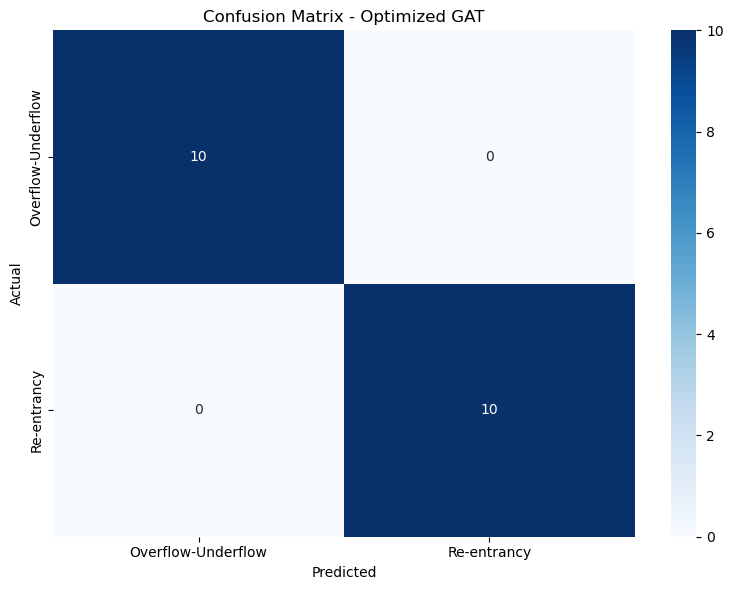

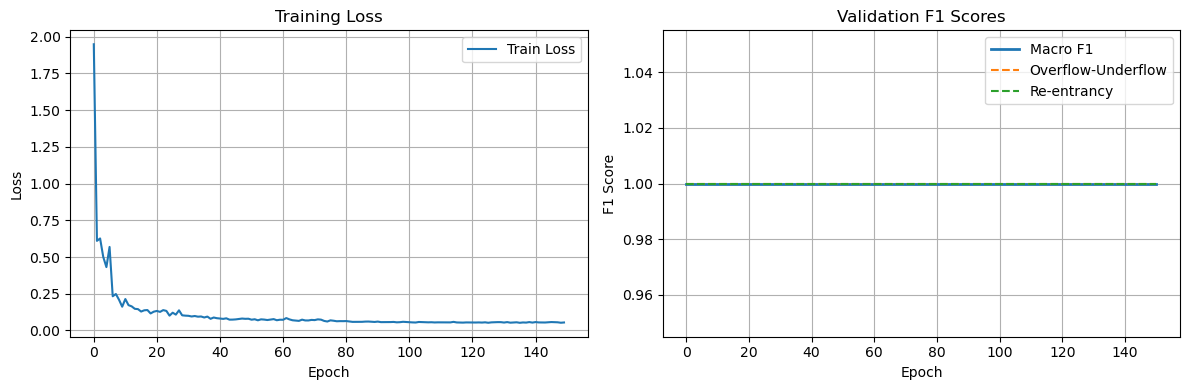


✅ Model saved to: .\saved_models\optimized_gat_ofu_re.pt

📋 TRAINING SUMMARY

┌────────────────────────────────────────────────────────────────┐
│                    OPTIMIZED GAT TRAINING RESULTS              │
├────────────────────────────────────────────────────────────────┤
│ Target Vulnerabilities:                                        │
│   • Overflow-Underflow (Arithmetic)                            │
│   • Re-entrancy                                                │
├────────────────────────────────────────────────────────────────┤
│ Dataset: SolidiFI-benchmark (80/20 split)                      │
│   • Train:   72 graphs (augmented to 216)               │
│   • Validation:    8 graphs                                   │
│   • Test:   20 graphs                                       │
├────────────────────────────────────────────────────────────────┤
│ Model: Optimized GAT                                           │
│   • Layers: 4, Heads: 4, Hidden: 128                      │

In [14]:
print("=" * 80)
print("📊 FINAL EVALUATION ON TEST SET")
print("=" * 80)

# Evaluate with optimized thresholds
results, test_f1, test_preds, test_labels = evaluate(model, test_loader, optimized_thresholds)

print("\n" + "=" * 65)
print(f"   {'Vulnerability':<20} {'Precision':>10} {'Recall':>10} {'F1-Score':>10} {'Support':>10}")
print("-" * 65)

for name, metrics in results.items():
    print(f"   {name:<20} {metrics['precision']:>10.4f} {metrics['recall']:>10.4f} "
          f"{metrics['f1']:>10.4f} {metrics['support']:>10}")

print("-" * 65)
print(f"   {'MACRO AVERAGE':<20} {'':<10} {'':<10} {test_f1:>10.4f}")
print("=" * 65)

# Confusion Matrix
print("\n📈 CONFUSION MATRIX")
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Overflow-Underflow', 'Re-entrancy'],
            yticklabels=['Overflow-Underflow', 'Re-entrancy'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Optimized GAT')
plt.tight_layout()
plt.savefig(os.path.join(MODEL_SAVE_DIR, 'confusion_matrix_optimized.png'), dpi=150)
plt.show()

# Training History
if len(history['val_f1']) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    axes[0].plot(history['train_loss'], label='Train Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    epochs = list(range(0, len(history['val_f1']) * 5, 5))
    axes[1].plot(epochs, history['val_f1'], label='Macro F1', linewidth=2)
    axes[1].plot(epochs, history['val_f1_ofu'], '--', label='Overflow-Underflow')
    axes[1].plot(epochs, history['val_f1_re'], '--', label='Re-entrancy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('F1 Score')
    axes[1].set_title('Validation F1 Scores')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(MODEL_SAVE_DIR, 'training_history_optimized.png'), dpi=150)
    plt.show()

# Save model
save_path = os.path.join(MODEL_SAVE_DIR, 'optimized_gat_ofu_re.pt')
torch.save({
    'model_state_dict': model.state_dict(),
    'optimized_thresholds': optimized_thresholds,
    'results': results,
    'test_f1': test_f1,
    'hyperparams': {
        'num_features': NUM_FEATURES,
        'hidden_channels': HIDDEN_CHANNELS,
        'num_heads': NUM_HEADS,
        'num_layers': NUM_LAYERS,
        'dropout': DROPOUT,
        'learning_rate': LEARNING_RATE,
        'focal_gamma': FOCAL_GAMMA,
    }
}, save_path)
print(f"\n✅ Model saved to: {save_path}")

# Summary
print("\n" + "=" * 80)
print("📋 TRAINING SUMMARY")
print("=" * 80)
print(f"""
┌────────────────────────────────────────────────────────────────┐
│                    OPTIMIZED GAT TRAINING RESULTS              │
├────────────────────────────────────────────────────────────────┤
│ Target Vulnerabilities:                                        │
│   • Overflow-Underflow (Arithmetic)                            │
│   • Re-entrancy                                                │
├────────────────────────────────────────────────────────────────┤
│ Dataset: SolidiFI-benchmark (80/20 split)                      │
│   • Train: {len(train_graphs):>4} graphs (augmented to {len(augmented_train)})               │
│   • Validation: {len(val_graphs):>4} graphs                                   │
│   • Test: {len(test_graphs):>4} graphs                                       │
├────────────────────────────────────────────────────────────────┤
│ Model: Optimized GAT                                           │
│   • Layers: {NUM_LAYERS}, Heads: {NUM_HEADS}, Hidden: {HIDDEN_CHANNELS}                      │
│   • Focal Loss (γ={FOCAL_GAMMA}), Label Smoothing ({LABEL_SMOOTHING})             │
├────────────────────────────────────────────────────────────────┤
│ Optimized Thresholds:                                          │
│   • Overflow-Underflow: {optimized_thresholds.get('Overflow-Underflow', 0.5):.2f}                             │
│   • Re-entrancy: {optimized_thresholds.get('Re-entrancy', 0.5):.2f}                                   │
├────────────────────────────────────────────────────────────────┤
│ Final Test Results:                                            │
│   • Overflow-Underflow F1: {results.get('Overflow-Underflow', {}).get('f1', 0):.4f}                        │
│   • Re-entrancy F1: {results.get('Re-entrancy', {}).get('f1', 0):.4f}                              │
│   • Macro F1: {test_f1:.4f}                                       │
└────────────────────────────────────────────────────────────────┘
""")
print("✅ Training pipeline complete!")